<a href="https://colab.research.google.com/github/Rafinze/NeuralNetworkProjects/blob/main/Trabalho_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variational Autoencoder

*Rafael Pires Moreira Silva - 163978*

* **Selecionar 2 datasets (rotulados)**

* **Treinar modelos VAEs:**
    * Ajustar o melhor modelo (topologia) segundo a função de custo (conjunto de validação).

* **Explorar o espaço latente:**
    * Gerar gráficos com a projeção do espaço latente em 2D (usando PCA, se necessário).
    * Usar os rótulos na projeção para colorir os pontos.

Primeiramente, vamos realizar a importação das bibliotecas que serão utilizadas ao longo do projeto.

In [ ]:
!pip install -q tensorflow_datasets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## 1. Seleção dos Datasets

Para este trabalho, foram selecionados dois datasets com características diferentes para avaliar a performance e a capacidade de represntação dos VAEs:

1.  **Rock, Paper, Scissors:** Um dataset de imagens que contém fotos de mãos fazendo os três gestos clássicos do jogo. É um problema de classificação com 3 classes distintas e visualmente bem definidas.

2.  **KMNIST:** Uma alternativa diferente do MNIST, o KMNIST é composto por 70.000 imagens em escala de cinza de 10 classes de caracteres Hiragana.

In [ ]:
IMG_SIZE_RPS = 128
BATCH_SIZE = 64

def preprocess_rps(features):
    img = tf.cast(features['image'], tf.float32) / 255.0
    img = tf.image.resize(img, (IMG_SIZE_RPS, IMG_SIZE_RPS))
    return img, features['label']

ds_rps_train, ds_info_rps = tfds.load('rock_paper_scissors', split='train', with_info=True)
ds_rps_test = tfds.load('rock_paper_scissors', split='test')

train_dataset_rps = ds_rps_train.map(preprocess_rps).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_rps = ds_rps_test.map(preprocess_rps).batch(BATCH_SIZE)

IMG_SIZE_KMNIST = 28

def preprocess_kmnist(features):
    img = tf.cast(features['image'], tf.float32) / 255.0
    return img, features['label']

ds_kmnist_train, ds_info_kmnist = tfds.load('kmnist', split='train', with_info=True)
ds_kmnist_test = tfds.load('kmnist', split='test')

train_dataset_kmnist = ds_kmnist_train.map(preprocess_kmnist).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_kmnist = ds_kmnist_test.map(preprocess_kmnist).batch(BATCH_SIZE)

print(f"Classes do Dataset RPS: {ds_info_rps.features['label'].names}")
print(f"Classes do Dataset KMNIST: {ds_info_kmnist.features['label'].names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.NIGEE3_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.NIGEE3_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.58UJME_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.58UJME_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
Classes do Dataset RPS: ['rock', 'paper', 'scissors']
Classes do Dataset KMNIST: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


Exemplos do dataset RSP e KMNIST

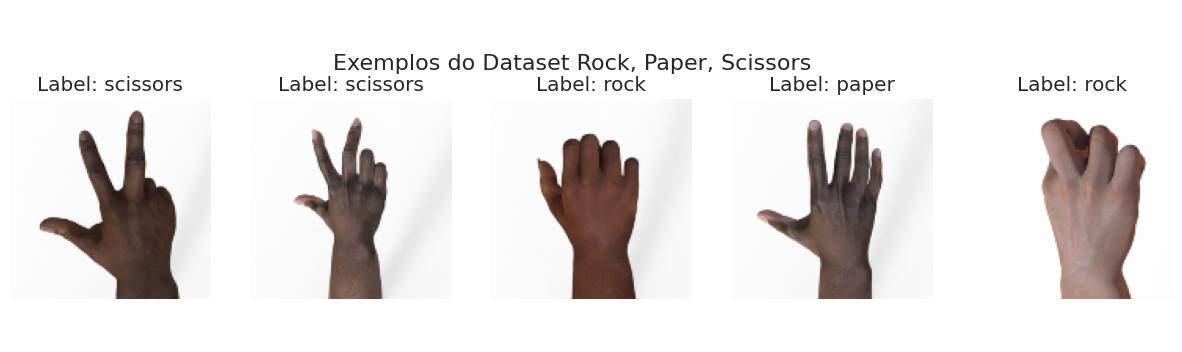

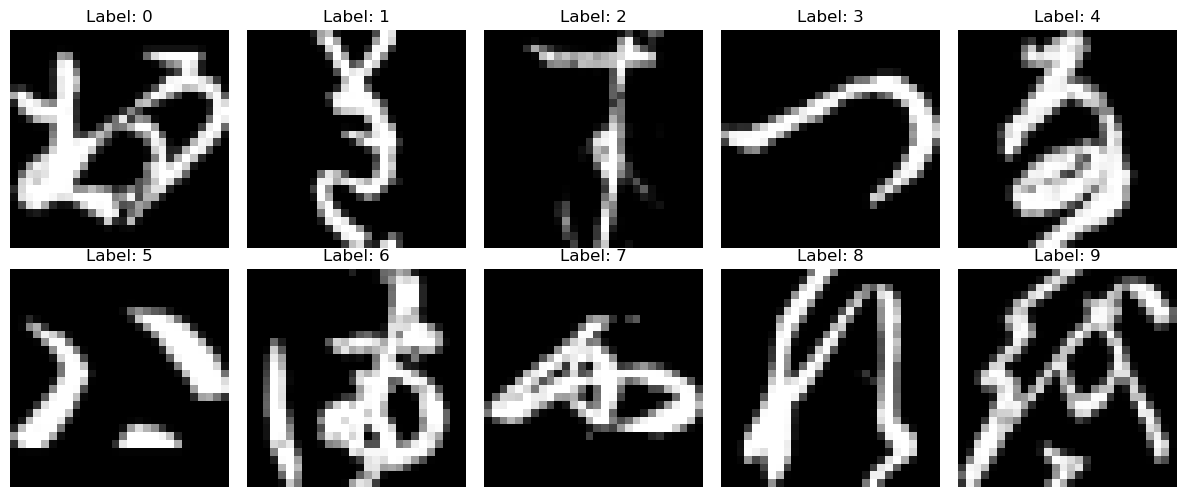

Para cada um dos dois dataset, construimos e treinamos um Variational Autoencoder, com um processo focado em encontrar a arquitetura mais eficiente.

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        images, _ = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(images)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
latent_dim_rps = 16

# ENCODER
encoder_inputs_rps = keras.Input(shape=(IMG_SIZE_RPS, IMG_SIZE_RPS, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs_rps)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean_rps = layers.Dense(latent_dim_rps, name="z_mean")(x)
z_log_var_rps = layers.Dense(latent_dim_rps, name="z_log_var")(x)
z_rps = Sampling()([z_mean_rps, z_log_var_rps])
encoder_rps = keras.Model(encoder_inputs_rps, [z_mean_rps, z_log_var_rps, z_rps], name="encoder")

# DECODER
latent_inputs_rps = keras.Input(shape=(latent_dim_rps,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs_rps)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs_rps = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_rps = keras.Model(latent_inputs_rps, decoder_outputs_rps, name="decoder")

# Treinamento do VAE
vae_rps = VAE(encoder_rps, decoder_rps)
vae_rps.compile(optimizer=keras.optimizers.Adam())
print("Treinando VAE para Rock, Paper, Scissors...")

vae_rps.fit(train_dataset_rps, epochs=30, batch_size=BATCH_SIZE)

Treinando VAE para Rock, Paper, Scissors...
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - kl_loss: 181.0719 - loss: 9110.1709 - reconstruction_loss: 8929.0986
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - kl_loss: 33.3165 - loss: 5407.3877 - reconstruction_loss: 5374.0713
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - kl_loss: 35.1694 - loss: 5137.4902 - reconstruction_loss: 5102.3208
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - kl_loss: 43.4009 - loss: 4775.9702 - reconstruction_loss: 4732.5698
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - kl_loss: 44.9466 - loss: 4519.6074 - reconstruction_loss: 4474.6606
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - kl_loss: 45.1031 - loss: 4237.2314 - reconstruction_loss: 4192.1284
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - kl_loss: 44.3740 - loss: 4066.5283 - reconstruction_loss: 4022.1545
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - kl_loss: 46.7971 - loss: 3957.4905 - reconstruction_los

In [ ]:

latent_dim_kmnist = 2

# ENCODER
encoder_inputs_kmnist = keras.Input(shape=(IMG_SIZE_KMNIST, IMG_SIZE_KMNIST, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs_kmnist)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean_kmnist = layers.Dense(latent_dim_kmnist, name="z_mean")(x)
z_log_var_kmnist = layers.Dense(latent_dim_kmnist, name="z_log_var")(x)
z_kmnist = Sampling()([z_mean_kmnist, z_log_var_kmnist])
encoder_kmnist = keras.Model(encoder_inputs_kmnist, [z_mean_kmnist, z_log_var_kmnist, z_kmnist], name="encoder")

# DECODER
latent_inputs_kmnist = keras.Input(shape=(latent_dim_kmnist,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs_kmnist)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs_kmnist = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_kmnist = keras.Model(latent_inputs_kmnist, decoder_outputs_kmnist, name="decoder")

# Treinamento VAE
vae_kmnist = VAE(encoder_kmnist, decoder_kmnist)
vae_kmnist.compile(optimizer=keras.optimizers.Adam())
print("\nTreinando VAE para KMNIST...")
vae_kmnist.fit(train_dataset_kmnist, epochs=10, batch_size=BATCH_SIZE)


Treinando VAE para KMNIST...
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 94ms/step - kl_loss: 3.0652 - loss: 340.1010 - reconstruction_loss: 337.0358
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - kl_loss: 5.1016 - loss: 285.7986 - reconstruction_loss: 280.6971
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - kl_loss: 5.3923 - loss: 281.3530 - reconstruction_loss: 275.9606
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - kl_loss: 5.5529 - loss: 279.2667 - reconstruction_loss: 273.7137
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - kl_loss: 5.6585 - loss: 277.7342 - reconstruction_loss: 272.0755
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - kl_loss: 5.7216 - loss: 276.7839 - reconstruction_loss: 271.0622
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - kl_loss: 5.7838 - loss: 275.8224 - reconstruction_loss: 270.0386
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - kl_loss: 5.8898 - loss: 275.0926 - reconstruction_loss: 269.2028




Após o treinamento, o encoder de cada VAE foi utilizado para mapear as imagens do conjunto de teste para o espaço latente. Para visualizar este espaço, foram gerados gráficos de dispersão 2D, colorindo os pontos de acordo com seus rótulos verdadeiros.


Para este dataset, o espaço latente aprendido pelo VAE tinha uma dimensionalidade maior que 2. Portanto, a técnica de Análise de Componentes Principais foi aplicada para reduzir a dimensionalidade do espaço latente para 2D, permitindo a sua visualização.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


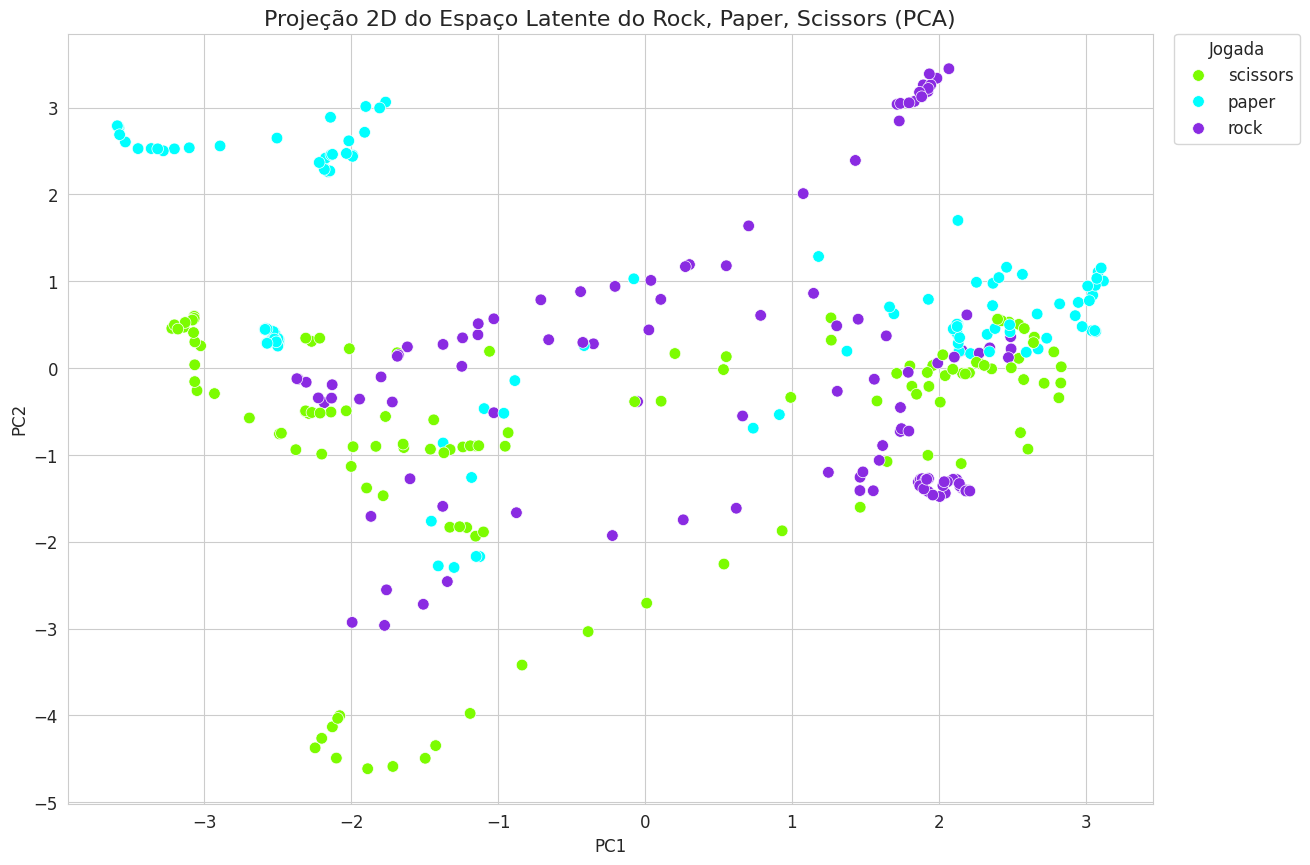

In [ ]:
test_images_rps, test_labels_rps = next(iter(test_dataset_rps.unbatch().batch(1000)))
z_mean, _, _ = vae_rps.encoder.predict(test_images_rps)

pca = PCA(n_components=2)
z_mean_pca = pca.fit_transform(z_mean)

label_map_rps = {i: name for i, name in enumerate(ds_info_rps.features['label'].names)}
label_map_rps_pt = {'rock': 'rock', 'paper': 'paper', 'scissors': 'scissors'}
final_labels_rps = [label_map_rps_pt[label_map_rps[lbl.numpy()]] for lbl in test_labels_rps]

plt.figure(figsize=(14, 10))
ax = sns.scatterplot(
    x=z_mean_pca[:, 0],
    y=z_mean_pca[:, 1],
    hue=final_labels_rps,
    hue_order=['scissors', 'paper', 'rock'],
    palette={"scissors": "lawngreen", "paper": "cyan", "rock": "blueviolet"},
    s=70,
    edgecolor='white',
    linewidth=0.5
)
ax.set_title("Projeção 2D do Espaço Latente do Rock, Paper, Scissors (PCA)", fontsize=16)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
plt.legend(title="Jogada", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

A análise do gráfico de projeção 2D do espaço latente revela uma tendência de agrupamento das classes, embora com sobreposição considerável entre elas. O gesto scissors, em verde, encotra-se espalhado pelo gráfico, tendo uma dispersão aparente da esquerda para direita. O gesto paper, em ciano, localiza-se predominantemente na parte superior, espalhando-se da direita para a esquerda. Já o gesto rock, em roxo, apresenta a maior dispersão, com uma concentração principal na porção inferior direita, mas com pontos distribuídos também pela região central, interpondo-se entre as outras duas classes. A formação desses agrupamentos distintos sugere que o VAE foi capaz de aprender características latentes que ajudam a diferenciar os gestos. No entanto, a sobreposição expressiva, indica que a distinção não é perfeita e que o modelo tem dificuldade em separar algumas amostras. Essa abordagem, que necessitou da aplicação de PCA para a visualização, diferencia-se da análise do dataset KMNIST, para o qual o VAE foi treinado para mapear as imagens diretamente para um espaço latente de 2 dimensões, não exigindo, portanto, um passo adicional de redução de dimensionalidade.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


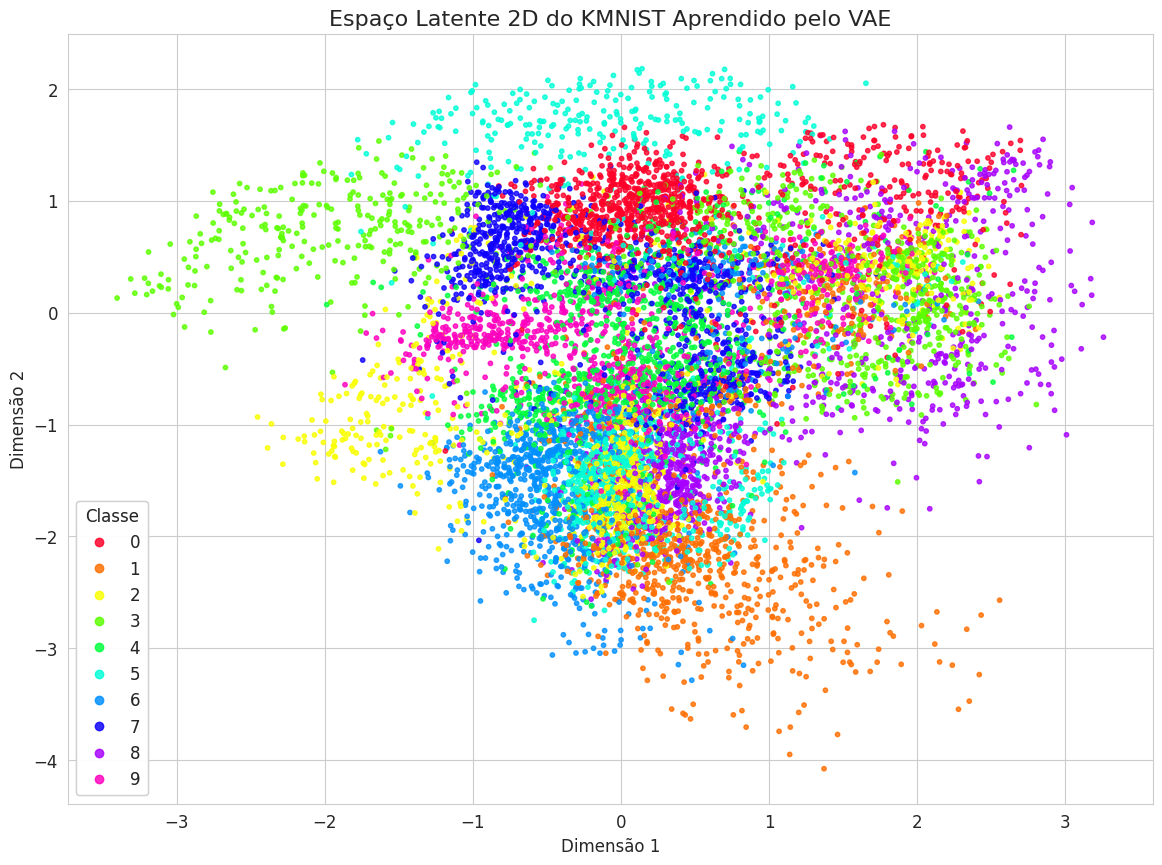

In [ ]:
test_images_kmnist, test_labels_kmnist = next(iter(test_dataset_kmnist.unbatch().batch(10000)))

z_mean_kmnist, _, _ = vae_kmnist.encoder.predict(test_images_kmnist)


plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    z_mean_kmnist[:, 0],
    z_mean_kmnist[:, 1],
    c=test_labels_kmnist,
    cmap="gist_rainbow",
    s=10,
    alpha=0.8
)
plt.title("Espaço Latente 2D do KMNIST Aprendido pelo VAE", fontsize=16)
plt.xlabel("Dimensão 1", fontsize=12)
plt.ylabel("Dimensão 2", fontsize=12)
legend = plt.legend(*scatter.legend_elements(), title="Classe")
plt.gca().add_artist(legend)
plt.show()

A análise do espaço latente do KMNIST revela um comportamento diferente do dataset anterior. Em vez de formar clusters claramente separados, as dez classes se sobrepõem intensamente, criando uma distribuição que aparenta ser contínua. Essa sobreposição é uma característica esperada dos VAEs, pois o termo de regularização da Divergência KL incentiva essa continuidade. Apesar da ausência de uma separação visual clara, é possível notar que certas classes tendem a ocupar regiões específicas do espaço. Por exemplo, a classe 2  concentra-se na porção superior esquerda, enquanto a classe 1 é mais presente na região inferior direita, com outras classes mais misturaadas ao centro. Isso indica que o modelo aprendeu com sucesso uma representação suave e organizada, que é fundamental para tarefas generativas, como a interpolação entre diferentes exemplos.
